# Physical Twin Reconfiguration Service

This is a reactive service that reconfigures the incubator physical twin (PT) whenever the difference between the temperature moving average and the actual temperature is high. It uses the values of the `MovingAverageTemperatureService` and matches them with the values coming from the physical twin.

A slight technicality is that the messages containing the moving average temperature (from `MovingAverageTemperatureService`), and the temperature (coming from the PT) come from two different sources. They are ordered according to timestamp in each of the corresponding sources but the order of their arrival is not necessarily by increasing value of timestamp. This means this service needs to aggregate them and rely on them having the same timestamp to conclude that a given moving temperature message corresponds to a given temperature measured. This is a process similar to the merge phase of the [merge sort algorithm](https://en.wikipedia.org/wiki/Merge_sort).

The algorithm to perform this alignment is illustrated in the following state machine which is then implemented in the PT reconfiguration service:

![](./reconfiguration_service_state_machine.svg)

In [30]:
# Configure python path to load incubator modules
import sys
import os

# Get the current working directory. Should be 1-Incubator-Service
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '1-Incubator-Service', 'Current directory is not 1-Incubator-Service'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

In [31]:
# Check that the average_service code is in the current directory
assert os.path.exists(os.path.join(current_dir, 'average_service.py')), 'average_service.py not found in the current directory. Run the previous notebooks in order.'

# Check that the moving_temperature_average_service code is in the current directory
assert os.path.exists(os.path.join(current_dir, 'moving_temperature_average_service.py')), 'moving_temperature_average_service.py not found in the current directory. Run the previous notebooks in order.'

# Check that logging configuration file is in the current directory
assert os.path.exists(os.path.join(current_dir, 'logging.conf')), 'logging.conf not found in the current directory. Run the previous notebooks in order.'

In [32]:
%%writefile pt_configuration_service.py

# Configure python path to load incubator modules
import sys
import os
import logging
import logging.config
import time
from collections import deque

# Get the current working directory. Should be 1-Incubator-Service
current_dir = os.getcwd()

assert os.path.basename(current_dir) == '1-Incubator-Service', 'Current directory is not 1-Incubator-Service'

# Get the parent directory. Should be the root of the repository
parent_dir = os.path.dirname(current_dir)

# The root of the repo should contain the incubator_dt folder. Otherwise something went wrong in 0-Pre-requisites.
assert os.path.exists(os.path.join(parent_dir, 'incubator_dt')), 'incubator_dt folder not found in the repository root'

incubator_dt_software_dir = os.path.join(parent_dir, 'incubator_dt', 'software')

assert os.path.exists(incubator_dt_software_dir), 'incubator_dt software directory not found'

# Add the parent directory to sys.path
sys.path.append(incubator_dt_software_dir)

from incubator.communication.server.rabbitmq import Rabbitmq
from incubator.communication.shared.protocol import ROUTING_KEY_STATE, ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS

class PTReconfigurationService:
    
    def __init__(self, max_diff, new_temp_desired, rabbitmq_config):

        self._rabbitmq = Rabbitmq(**rabbitmq_config)
        
        self._max_diff = max_diff # Maximum tolerated difference.
        assert self._max_diff > 0, "max_diff must be greater than 0."
        self._new_temp_desired = new_temp_desired # New desired temperature to set in the incubator in case there's an anomaly
        
        self._l = logging.getLogger("PTReconfigurationService")

        self.avg = None
        self.temp = None
        self.lt = None
        self.state = "Start"

    def setup(self):
        self._rabbitmq.connect_to_server()

        # Subscribe to any message coming from the incubator physical twin, and any message from the moving average service.
        self._rabbitmq.subscribe(routing_key=ROUTING_KEY_STATE,
                                on_message_callback=self.process_state_sample)
                                
                                # Notice the routing key we're suscribing to. This is the same routing key that the moving average service uses to publish its outputs. 
        self._rabbitmq.subscribe(routing_key="incubator.record.dtcourse.moving_temperature_average_service.temperature_moving_average", 
                                on_message_callback=self.process_moving_average)

        self._l.info(f"PTReconfigurationService setup complete.")

    def state_machine_step(self, nt, ntemp=None, navg=None):
        assert ntemp is not None or navg is not None, "Expected at least one of ntemp or navg to be not None."

        if self.state == "Start":
            assert self.temp is None
            assert self.avg is None
            assert self.lt is None
            if ntemp is not None:
                self.lt = nt
                self.temp = ntemp
                self.state = "TempDefined"
                self._l.info(f"Stored temperature reading: {self.temp} and time {self.lt}. New state: {self.state}")
                return
            if navg is not None:
                self.lt = nt
                self.avg = navg
                self.state = "AvgDefined"
                self._l.info(f"Stored moving average: {self.avg} and time {self.lt}. New state: {self.state}")
                return

            assert False, "Should not reach here."
            return 

        if self.state == "TempDefined":
            assert self.temp is not None
            assert self.lt is not None
            assert self.avg is None

            # get new timestamp
            new_lt = nt

            if new_lt == self.lt and ntemp is not None:
                self._l.warning(f"Received duplicate timestamp. Ignoring.")
                return
            
            if new_lt < self.lt:
                self._l.warning(f"Received out-of-order timestamp. Ignoring.")
                return

            if new_lt > self.lt:
                if ntemp is not None:
                    self.temp = ntemp
                    self.lt = new_lt
                    self._l.info(f"Received more recent timestamp and ntemp: {self.temp} and time {self.lt}. New state: {self.state}")
                    return
                if navg is not None:
                    self.avg = navg
                    self.lt = new_lt
                    self.temp = None
                    self.state = "AvgDefined"
                    self._l.info(f"Received more recent timestamp and navg: {self.avg} and time {self.lt}. New state: {self.state}")
                    return
            
            if new_lt == self.lt and navg is not None:
                self.avg = navg
                self.state = "TempAvgMatch"
                self._l.info(f"Received same timestamp and navg: {self.avg} and time {self.lt}. New state: {self.state}")
                return
            
            assert False, "Should not reach here."
            return
        
        if self.state == "AvgDefined":
            assert self.temp is None
            assert self.lt is not None
            assert self.avg is not None

            # get new timestamp
            new_lt = nt

            if new_lt == self.lt and navg is not None:
                self._l.warning(f"Received duplicate timestamp. Ignoring.")
                return
            
            if new_lt < self.lt:
                self._l.warning(f"Received out-of-order timestamp. Ignoring.")
                return

            if new_lt > self.lt:
                if ntemp is not None:
                    self.avg = None
                    self.lt = new_lt
                    self.temp = ntemp
                    self.state = "TempDefined"
                    self._l.info(f"Received more recent timestamp and ntemp: {self.temp} and time {self.lt}. New state: {self.state}")
                    return
                if navg is not None:
                    self.avg = navg
                    self.lt = new_lt
                    self._l.info(f"Received more recent timestamp and navg: {self.avg} and time {self.lt}. New state: {self.state}")
                    return
            
            if new_lt == self.lt and ntemp is not None:
                self.temp = ntemp
                self.state = "TempAvgMatch"
                self._l.info(f"Received same timestamp and ntemp: {self.temp} and time {self.lt}. New state: {self.state}")
                return
            
            assert False, "Should not reach here."
            return
        
        if self.state == "TempAvgMatch":
            assert self.temp is not None
            assert self.lt is not None
            assert self.avg is not None

            self.check_if_reconfiguration_needed()

            self.temp = None
            self.avg = None
            self.lt = None
            self.state = "Start"

            self._l.info(f"Reconfiguration done. New state: {self.state}")
            return

        assert False, "Should not reach here."
        return

    def process_state_sample(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received state sample: {body_json}")

        # Run the state machine documented above.
        nt = body_json["time"]
        ntemp = body_json["fields"]["average_temperature"]

        self.state_machine_step(nt, ntemp=ntemp, navg=None)

    def process_moving_average(self, ch, method, properties, body_json):
        # Log the values received.
        self._l.info(f"Received moving average result: {body_json}")

        # Run the state machine documented above.
        nt = body_json["time"]
        navg = body_json["fields"]["moving_average_temperature"]

        self.state_machine_step(nt, ntemp=None, navg = navg)

    def check_if_reconfiguration_needed(self):
        
        diff = abs(self.temp - self.avg)
        
        # Prepare a message to publish under a new topic representing this service's data stream. We reuse the same timestamp from the original message, to enable easier traceability between outputs and inputs.
        timestamp = self.lt

        # The format of this message will become later. This is just to allow a uniform way to send data to the database.
        record_message = {
            "measurement": "pt_configuration_service",
            "time": timestamp,
            "tags": {
                "source": "pt_configuration_service"
            },
            "fields": {
                "difference": diff,
            }
        }

        # Log message
        self._l.info(f"Sending message: {record_message}")
        # Publish the message to the RabbitMQ server, just to record this service's output.
        self._rabbitmq.send_message("incubator.record.dtcourse.pt_configuration_service.temperature_moving_average", record_message)

        if diff <= self._max_diff:
            self._l.info(f"No reconfiguration needed. Temp: {self.temp} and Avg: {self.avg}. Difference: {diff}")
            return 

        self._l.info(f"Reconfiguration needed. Temp: {self.temp} and Avg: {self.avg}. Difference: {diff}")

        # Publish message reconfiguring the incubator by setting the desired temperature to a small value.
        self._rabbitmq.send_message(ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS, {
            "temperature_desired": self._new_temp_desired,
        })

        return
    
    def start_serving(self):
        self._rabbitmq.start_consuming()
    
if __name__ == "__main__":
    # Get utility functions to config logging and load configuration
    from incubator.config.config import load_config
    from pyhocon import ConfigFactory
    
    # Get logging configuration
    logging.config.fileConfig("logging.conf")

    # Get path to the startup.conf file used in the incubator dt:
    startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
    assert os.path.exists(startup_conf), 'startup.conf file not found'

    # The startup.conf comes from the incubator dt repository.
    config = ConfigFactory.parse_file(startup_conf)
    service = PTReconfigurationService(max_diff=1.0, new_temp_desired=25.0, rabbitmq_config=config["rabbitmq"])

    service.setup()
    
    # Start the PTReconfigurationService
    service.start_serving()

Overwriting pt_configuration_service.py


In [33]:
# You can run this, or you can run the command below in a new terminal windows to start the service
import subprocess
import time

# Start a process asynchronously
avg_service_proc = subprocess.Popen(["python", "average_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"average_service = {avg_service_proc.pid}")

average_service = 1392


In [34]:
# Print contents of log file to verify that the service is running
with open('AverageService.log', 'r') as f:
    print(f.read())


2024-10-19 11:58:46.710 DEBUG AverageService : Connected.
2024-10-19 11:58:46.716 DEBUG AverageService : Ready to listen for msgs in queue incubator.dtcourse.average_service bound to topic incubator.dtcourse.average_service
2024-10-19 11:58:46.716 INFO AverageService : AverageService setup complete.



In [35]:
# Start a process asynchronously
moving_temperature_average_service_proc = subprocess.Popen(["python", "moving_temperature_average_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"moving_temperature_average_service = {moving_temperature_average_service_proc.pid}")

moving_temperature_average_service = 37664


In [36]:
# Print contents of log file to verify that the service is running
with open('MovingAverageTemperatureService.log', 'r') as f:
    print(f.read())


2024-10-19 11:58:51.731 DEBUG MovingAverageTemperatureService : Connected.
2024-10-19 11:58:51.738 DEBUG MovingAverageTemperatureService : Ready to listen for msgs in queue incubator.dtcourse.moving_temperature_average_service bound to topic incubator.dtcourse.moving_temperature_average_service
2024-10-19 11:58:51.742 INFO MovingAverageTemperatureService : Bound incubator.record.driver.state--> amq.gen-JDcEtX3As-O-vW4AhmL4Mg
2024-10-19 11:58:51.796 INFO MovingAverageTemperatureService : MovingAverageTemperatureService setup complete.
2024-10-19 11:58:54.581 INFO MovingAverageTemperatureService : Received state sample: {'measurement': 'low_level_driver', 'time': 1729331934532181400, 'tags': {'source': 'low_level_driver'}, 'fields': {'t1': 21.313188128827775, 'time_t1': 1729331934531191100, 't2': 27.313188128827775, 'time_t2': 1729331934532181400, 't3': 21.0, 'time_t3': 1729331934532181400, 'average_temperature': 24.313188128827775, 'heater_on': True, 'fan_on': True, 'execution_interval'

In [37]:
# Start a process asynchronously
pt_configuration_service_proc = subprocess.Popen(["python", "pt_configuration_service.py"])

# Wait for 5 seconds for the process to start
time.sleep(5)

# Print the PID of the process. You can search for this in your task manager to see the process running and kill it if necessary.
print(f"pt_configuration_service = {pt_configuration_service_proc.pid}")

# Check that none of the process have crashed
assert avg_service_proc.poll() is None, "average_service has crashed"
assert moving_temperature_average_service_proc.poll() is None, "moving_temperature_average_service has crashed"
assert pt_configuration_service_proc.poll() is None, "pt_configuration_service has crashed"

pt_configuration_service = 25924


In [38]:
# Print contents of log file to verify that the service is running
with open('PTReconfigurationService.log', 'r') as f:
    print(f.read())


2024-10-19 11:58:56.782 INFO PTReconfigurationService : PTReconfigurationService setup complete.
2024-10-19 11:58:57.701 INFO PTReconfigurationService : Received state sample: {'measurement': 'low_level_driver', 'time': 1729331937655166200, 'tags': {'source': 'low_level_driver'}, 'fields': {'t1': 21.367762672249093, 'time_t1': 1729331937655166200, 't2': 27.367762672249093, 'time_t2': 1729331937655166200, 't3': 21.0, 'time_t3': 1729331937655166200, 'average_temperature': 24.367762672249093, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.12791180610656738}}
2024-10-19 11:58:57.701 INFO PTReconfigurationService : Stored temperature reading: 24.367762672249093 and time 1729331937655166200. New state: TempDefined
2024-10-19 11:58:57.754 INFO PTReconfigurationService : Received moving average result: {'measurement': 'moving_temperature_average_service', 'time': 1729331937655166200, 'tags': {'source': 'moving_temperature_average_service'}, 'fields': {'moving_avera

Now that the services are up and running, open the time series database management page (username and password are given in the incubator DT documentation), and explore the data to see the average temperature service output. Create a query as follows:
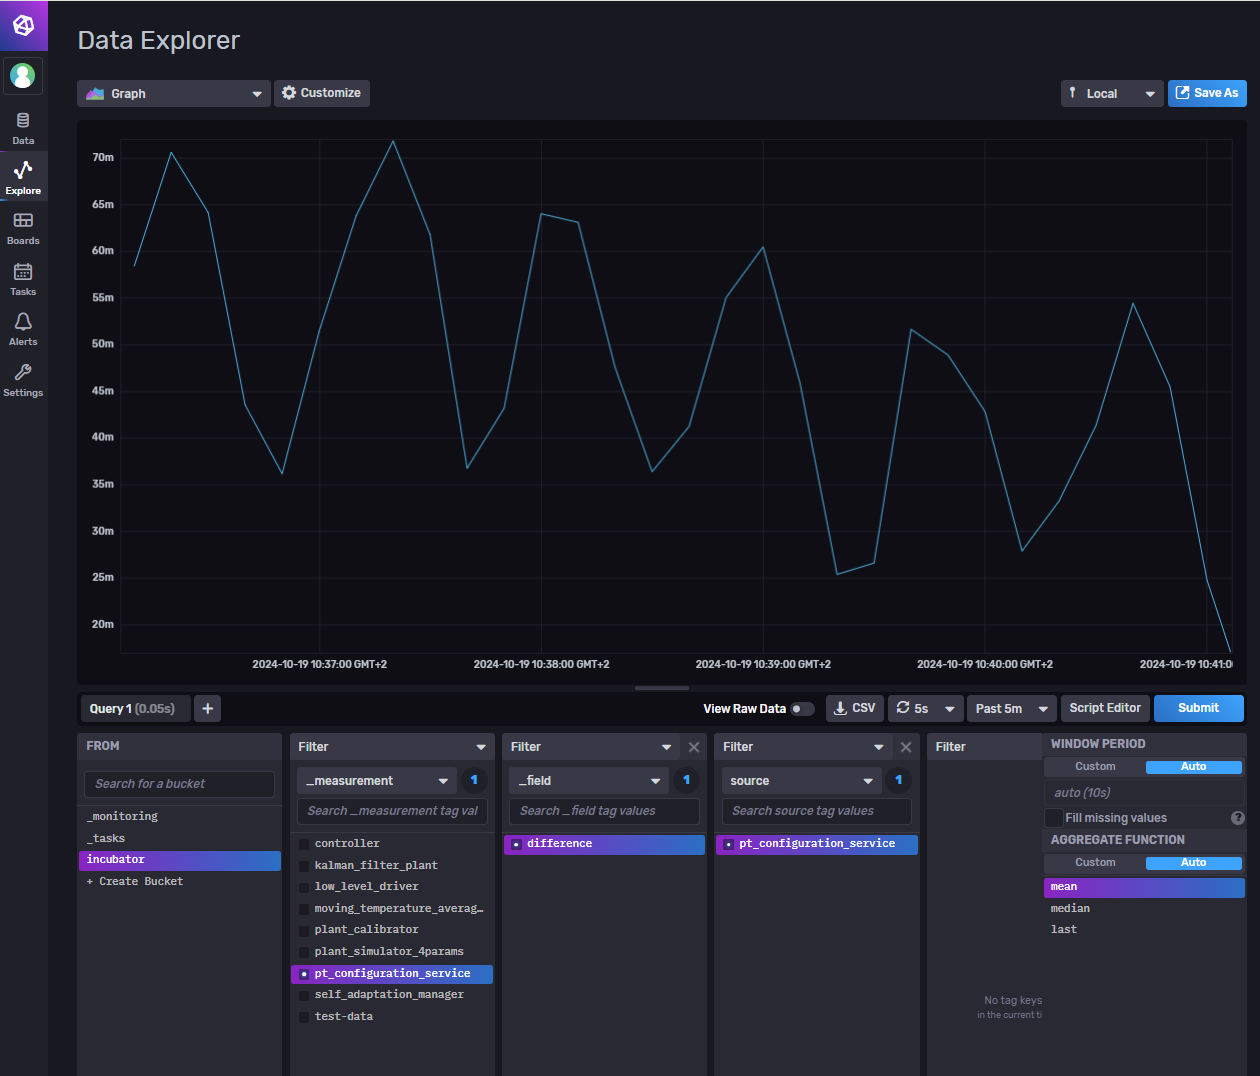

## Simulate the opening of the lid

Now that the service is running let us send a message to the PT, to simulate the opening of the lid.

In [39]:
# Import RPCClient class from incubator, which makes connecting to RabbitMQ and calling remote methods easy.
from incubator.communication.server.rabbitmq import Rabbitmq
from mock_plant.mock_connection import MOCK_G_BOX
from pyhocon import ConfigFactory

# Get config
startup_conf = os.path.join(os.path.dirname(os.getcwd()), 'incubator_dt', 'software','startup.conf')
config = ConfigFactory.parse_file(startup_conf)

lid_opening_factor = 1.0 # This is the factor by which the lid is opened. It's a value between 0.0 (Fully closed) and 1.0 (Fully open).
assert 0 <= lid_opening_factor <= 1, "lid_opening_factor must be between 0 and 1."

default_g_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
new_gbox = default_g_box + 10*lid_opening_factor * default_g_box

# Send a message to the PT to simulate the lid opening by a factor
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(MOCK_G_BOX, {"G_box": new_gbox})

# Wait a bit for the message to be processed
time.sleep(5)

# Check that the PT Reconfiguration Service has not crashed
assert pt_configuration_service_proc.poll() is None, "pt_configuration_service has crashed"

In [40]:
# Print contents of log file to verify that the service is running
with open('PTReconfigurationService.log', 'r') as f:
    print(f.read())


2024-10-19 11:58:56.782 INFO PTReconfigurationService : PTReconfigurationService setup complete.
2024-10-19 11:58:57.701 INFO PTReconfigurationService : Received state sample: {'measurement': 'low_level_driver', 'time': 1729331937655166200, 'tags': {'source': 'low_level_driver'}, 'fields': {'t1': 21.367762672249093, 'time_t1': 1729331937655166200, 't2': 27.367762672249093, 'time_t2': 1729331937655166200, 't3': 21.0, 'time_t3': 1729331937655166200, 'average_temperature': 24.367762672249093, 'heater_on': False, 'fan_on': True, 'execution_interval': 3.0, 'elapsed': 0.12791180610656738}}
2024-10-19 11:58:57.701 INFO PTReconfigurationService : Stored temperature reading: 24.367762672249093 and time 1729331937655166200. New state: TempDefined
2024-10-19 11:58:57.754 INFO PTReconfigurationService : Received moving average result: {'measurement': 'moving_temperature_average_service', 'time': 1729331937655166200, 'tags': {'source': 'moving_temperature_average_service'}, 'fields': {'moving_avera

If you take a look at the PT Reconfiguration Service different output, you may see something like this:

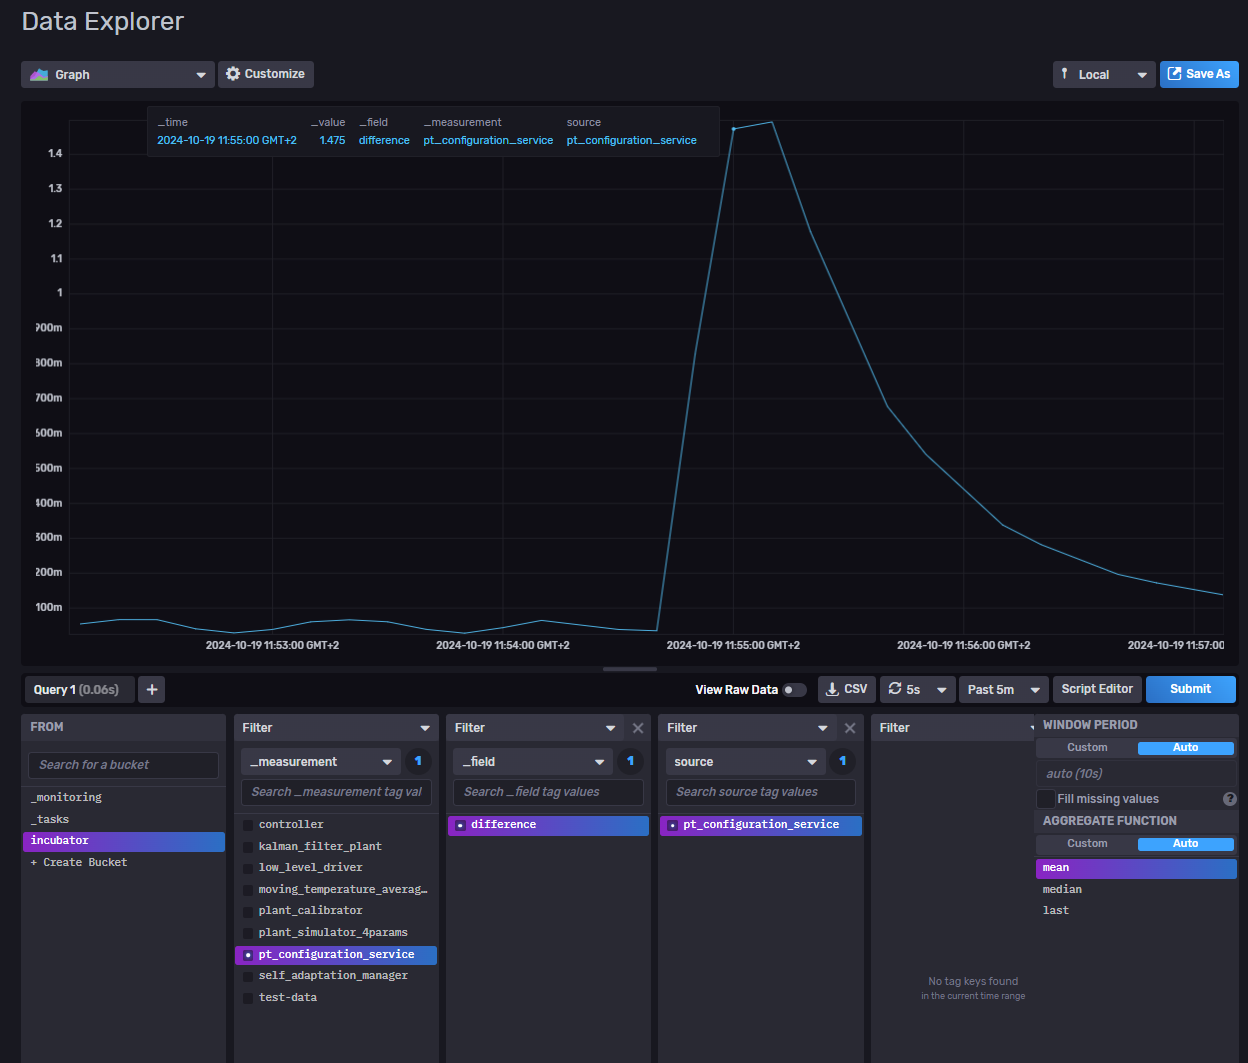

And if you create a dashboard to show the incubator data as well as the reconfiguration service output, you will see something like this:

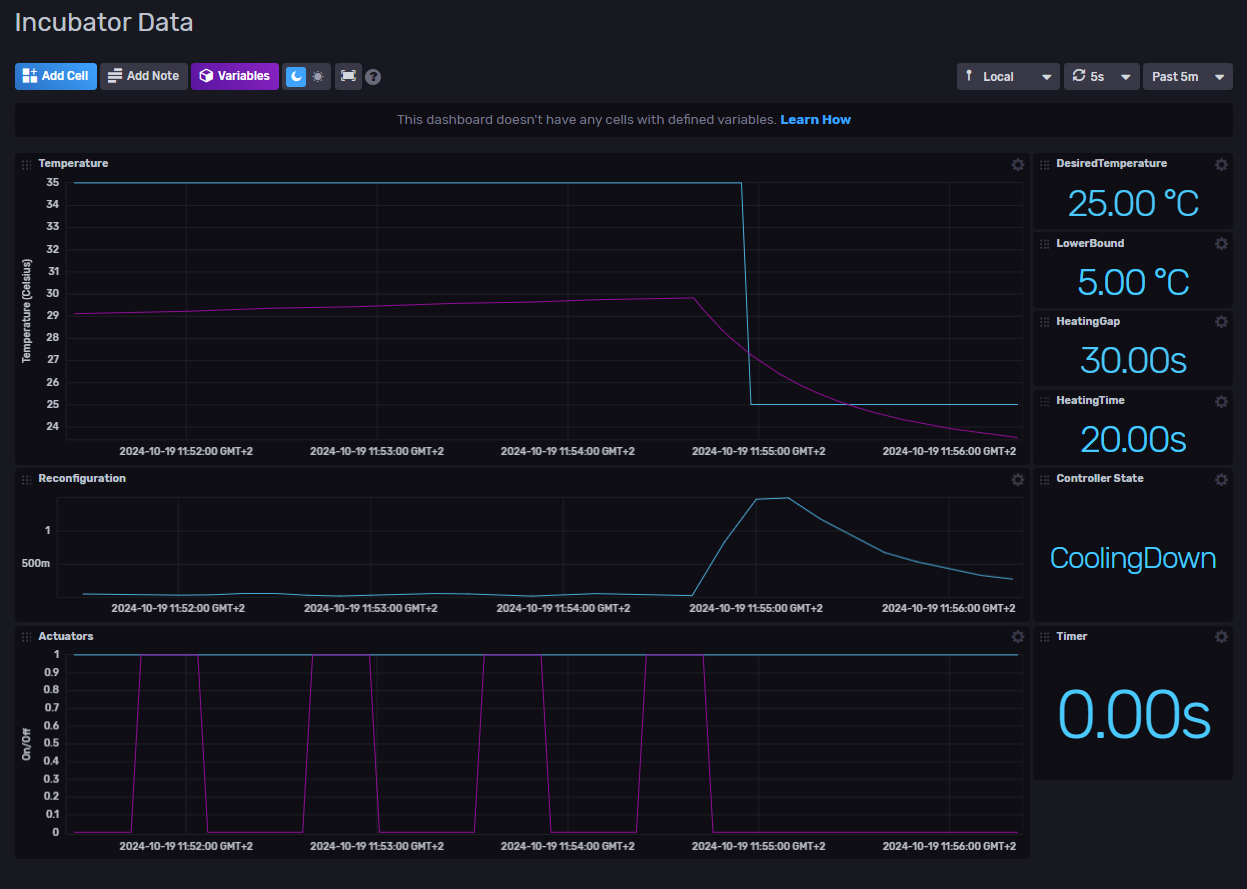

As can be seen above, the service did it's job: when the temperature became too different then the moving average it sent a message to the physical twin to change the desired temperature to a lower value of 25 degrees. 

## Ajusting the Controller and Restoring Lid

Let us now instruct manually set a new desired temperature on the controller, and restore the lid to its original place.

In [41]:
from incubator.communication.shared.protocol import ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS

default_g_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
new_temperature_desired = 35.0

# Send a message to the PT to simulate the lid opening by a factor
with Rabbitmq(**config["rabbitmq"]) as rabbitmq:
    rabbitmq.send_message(MOCK_G_BOX, {"G_box": default_g_box})
    rabbitmq.send_message(ROUTING_KEY_UPDATE_CLOSED_CTRL_PARAMS, {"temperature_desired": new_temperature_desired})

# Wait a bit for the message to be processed
time.sleep(5)

# Check that the PT Reconfiguration Service has not crashed
assert pt_configuration_service_proc.poll() is None, "pt_configuration_service has crashed"

You should now see the new temperature desired in the incubator data dashboard.

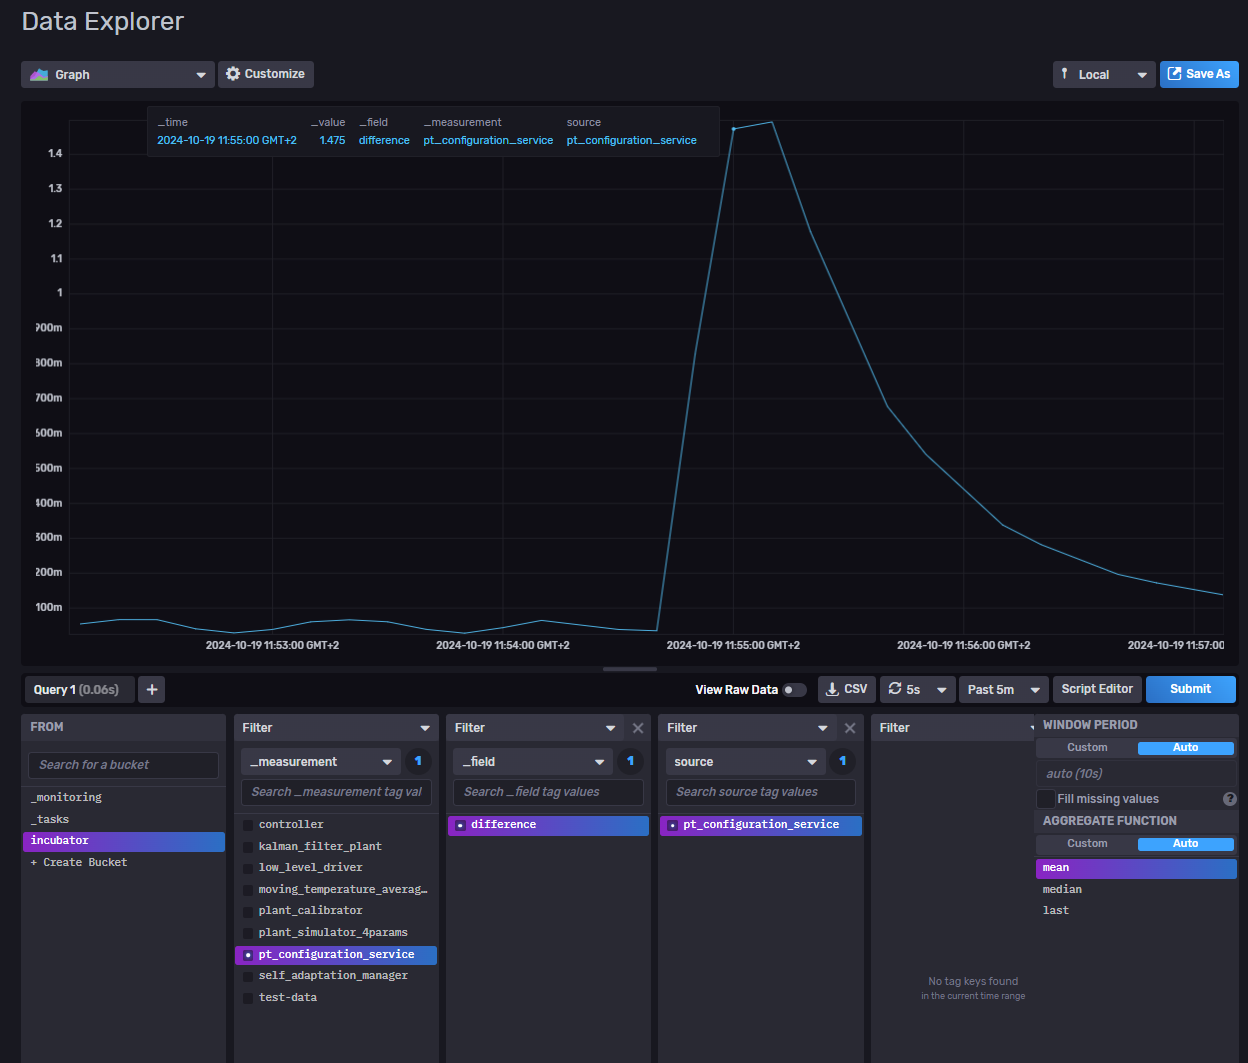

In [42]:
pt_configuration_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
pt_configuration_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert pt_configuration_service_proc.returncode is not None, 'Process has not exited'

In [43]:
moving_temperature_average_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
moving_temperature_average_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert moving_temperature_average_service_proc.returncode is not None, 'Process has not exited'

In [44]:
avg_service_proc.terminate() # Terminate the process. Send SIGTERM signal to the process. The process can catch this signal and perform cleanup operations before exiting, so we wait.
avg_service_proc.wait()  # Wait for the process to exit fully. Should print exit code 1, due to interruption.

# Ensure process has exited
assert avg_service_proc.returncode is not None, 'Process has not exited'